In [1]:
#Celda 0: Verificación del entorno

import pandas as pd, numpy as np, sklearn, xgboost
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)


pandas: 2.3.3
numpy: 2.3.5
scikit-learn: 1.7.2
xgboost: 3.1.2


In [2]:
# Celda 1: Generación de datos ficticios

import numpy as np
import pandas as pd

np.random.seed(42)
n = 100  # número de registros

df = pd.DataFrame({
    "amount": np.random.randint(10, 1000, n),
    "channel": np.random.choice(["WEB","ATM","POS"], n),
    "timestamp": pd.date_range("2025-01-01", periods=n, freq="h"),
    "fraud": np.random.choice([0,1], n, p=[0.9,0.1])
})

# Renombrar columna para consistencia
df.rename(columns={"fraud": "is_fraud"}, inplace=True)
df["is_fraud"] = df["is_fraud"].astype(int)

print("📊 Base ficticia generada:")
display(df.head())


📊 Base ficticia generada:


,amount,channel,timestamp,is_fraud
0,112,ATM,2025-01-01 00:00:00,0
1,445,ATM,2025-01-01 01:00:00,0
2,870,ATM,2025-01-01 02:00:00,0
3,280,ATM,2025-01-01 03:00:00,1
4,116,POS,2025-01-01 04:00:00,0


In [3]:
# Celda 2: Agregados por hora y canal

df["hour_bucket"] = df["timestamp"].dt.floor("h")
df["fraud_flag_int"] = df["is_fraud"].astype(int)

agg = (
    df.groupby(["hour_bucket", "channel"])
      .agg(tx_count=("fraud_flag_int", "count"),
           fraud_count=("fraud_flag_int", "sum"))
      .reset_index()
)

# Calcular tasa de fraude
agg["fraud_rate"] = agg["fraud_count"] / agg["tx_count"]

print("📊 Agregados por hora y canal:")
display(agg.head())

📊 Agregados por hora y canal:


,hour_bucket,channel,tx_count,fraud_count,fraud_rate
0,2025-01-01 00:00:00,ATM,1,0,0.0
1,2025-01-01 01:00:00,ATM,1,0,0.0
2,2025-01-01 02:00:00,ATM,1,0,0.0
3,2025-01-01 03:00:00,ATM,1,1,1.0
4,2025-01-01 04:00:00,POS,1,0,0.0


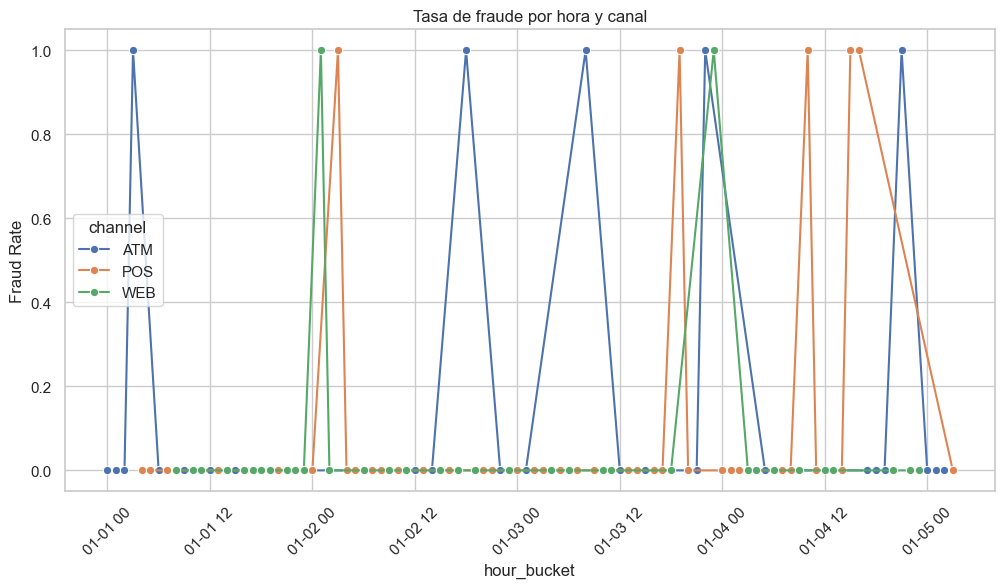

In [4]:
# Celda 3: Gráfica de tasa de fraude

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

sns.lineplot(data=agg, x="hour_bucket", y="fraud_rate", hue="channel", marker="o")
plt.title("Tasa de fraude por hora y canal")
plt.xticks(rotation=45)
plt.ylabel("Fraud Rate")
plt.show()

In [5]:
# Celda 4: Colas M/M/1 y M/M/c
import math

def mm1_metrics(lmbda, mu):
    rho = lmbda / mu
    if rho >= 1:
        return {"Modelo": "M/M/1", "Estable": False, "Rho": float(rho)}
    Lq = (rho**2) / (1 - rho)
    Wq = Lq / lmbda
    W = Wq + (1 / mu)
    L = lmbda * W
    return {"Modelo": "M/M/1", "Estable": True, "Rho": float(rho),
            "Lq": Lq, "Wq_min": Wq, "W_min": W, "L": L}

def mmc_metrics(lmbda, mu, servers):
    a = lmbda / mu
    rho = a / servers
    if rho >= 1:
        return {"Modelo": "M/M/c", "Estable": False, "Rho": float(rho)}
    sum_terms = sum((a**n) / math.factorial(n) for n in range(servers))
    P0 = 1.0 / (sum_terms + (a**servers) / (math.factorial(servers) * (1 - rho)))
    Pc = ((a**servers) / math.factorial(servers)) * (P0 / (1 - rho))
    Wq = Pc * (1 / mu) * (1 / (servers - a))
    W = Wq + (1 / mu)
    Lq = lmbda * Wq
    L = lmbda * W
    return {"Modelo": "M/M/c", "Estable": True, "Rho": float(rho),
            "P_espera": Pc, "Lq": Lq, "Wq_min": Wq, "W_min": W, "L": L}

lambda_h = df["is_fraud"].sum()
mu_h = 12
c = 5

mm1 = mm1_metrics(lambda_h/60, mu_h/60)
mmc = mmc_metrics(lambda_h/60, mu_h/60, c)

df_queues = pd.DataFrame([mm1, mmc])
print("📊 Resultados de modelos de colas:")
display(df_queues)


📊 Resultados de modelos de colas:


,Modelo,Estable,Rho,P_espera,Lq,Wq_min,W_min,L
0,M/M/1,False,1.0,NaN,NaN,NaN,NaN,NaN
1,M/M/c,True,0.2,0.003831,0.000958,0.004789,5.004789,1.000958


In [6]:
# Celda 5: Reglas de asociación corregida
from mlxtend.frequent_patterns import apriori, association_rules

# Indicadores binarios
df["is_high_amount"] = df["amount"] > 1000
df["is_night"] = df["timestamp"].dt.hour.isin([0,1,2,3,4,23])

# One-hot de canales
channels = pd.get_dummies(df["channel"], prefix="channel")

# Matriz booleana
basket = pd.concat([df[["is_fraud","is_high_amount","is_night"]], channels], axis=1).astype(bool)

# Itemsets frecuentes con soporte más bajo (ej. 0.05 = 5%)
freq = apriori(basket, min_support=0.05, use_colnames=True)

# Reglas de asociación
rules = association_rules(freq, metric="lift", min_threshold=1.0)

# Top reglas
top_rules = rules.sort_values("lift", ascending=False).head(10)

print("📊 Top 10 reglas de asociación (con soporte mínimo 5%):")
display(top_rules[["antecedents","consequents","support","confidence","lift"]])


📊 Top 10 reglas de asociación (con soporte mínimo 5%):


,antecedents,consequents,support,confidence,lift
0,(is_fraud),(channel_ATM),0.05,0.416667,1.602564
1,(channel_ATM),(is_fraud),0.05,0.192308,1.602564
5,(is_night),(channel_ATM),0.08,0.285714,1.098901
4,(channel_ATM),(is_night),0.08,0.307692,1.098901
3,(channel_POS),(is_fraud),0.05,0.128205,1.068376
2,(is_fraud),(channel_POS),0.05,0.416667,1.068376
6,(channel_POS),(is_night),0.11,0.282051,1.007326
7,(is_night),(channel_POS),0.11,0.392857,1.007326


In [7]:
# Celda 6: Entrenamiento de modelos corregida y extendida

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Features y target
df["hour"] = df["timestamp"].dt.hour  # crear columna 'hour' a partir de timestamp
X = df[["amount", "hour"]]
y = df["is_fraud"]

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Entrenar RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Entrenar XGBoost
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Mostrar resultados
print("✅ Modelos entrenados y predicciones generadas")
print("\n📊 Primeras predicciones RandomForest:", rf_pred[:10])
print("📊 Primeras predicciones XGBoost:", xgb_pred[:10])

print("\n🔎 Importancia de variables RandomForest:")
for feature, importance in zip(X.columns, rf.feature_importances_):
    print(f" - {feature}: {importance:.4f}")

print("\n🔎 Importancia de variables XGBoost:")
for feature, importance in zip(X.columns, xgb_model.feature_importances_):
    print(f" - {feature}: {importance:.4f}")



✅ Modelos entrenados y predicciones generadas

📊 Primeras predicciones RandomForest: [0 0 0 0 0 0 0 0 0 0]
📊 Primeras predicciones XGBoost: [0 0 0 0 0 0 0 1 0 0]

🔎 Importancia de variables RandomForest:
 - amount: 0.6655
 - hour: 0.3345

🔎 Importancia de variables XGBoost:
 - amount: 0.4881
 - hour: 0.5119


In [8]:
# Celda 7: Evaluación y visualizaciones corregida

from sklearn.metrics import classification_report
import pandas as pd

# Guardar reportes como DataFrame para poder usarlos después
rf_report = pd.DataFrame(
    classification_report(y_test, rf_pred, zero_division=0, output_dict=True)
).T

xgb_report = pd.DataFrame(
    classification_report(y_test, xgb_pred, zero_division=0, output_dict=True)
).T

print("📊 Reporte RandomForest:")
display(rf_report)

print("📊 Reporte XGBoost:")
display(xgb_report)



📊 Reporte RandomForest:


,precision,recall,f1-score,support
0,0.90,1.0,0.947368,27.0
1,0.00,0.0,0.000000,3.0
accuracy,0.90,0.9,0.900000,0.9
macro avg,0.45,0.5,0.473684,30.0
weighted avg,0.81,0.9,0.852632,30.0


📊 Reporte XGBoost:


,precision,recall,f1-score,support
0,0.896552,0.962963,0.928571,27.000000
1,0.000000,0.000000,0.000000,3.000000
accuracy,0.866667,0.866667,0.866667,0.866667
macro avg,0.448276,0.481481,0.464286,30.000000
weighted avg,0.806897,0.866667,0.835714,30.000000


📊 Comparación de métricas (Weighted Avg):


,precision,recall,f1-score
RandomForest,0.810000,0.900000,0.852632
XGBoost,0.806897,0.866667,0.835714


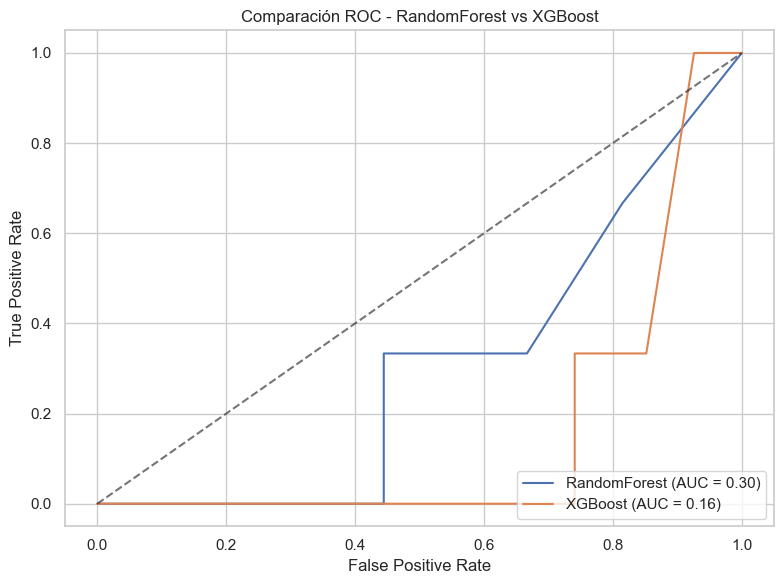

In [9]:
# Celda 8: comparación de métricas y curva ROC

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1) Resumen de métricas (usa rf_report y xgb_report creados en Celda 7)
rf_sum = rf_report.loc["weighted avg", ["precision", "recall", "f1-score"]]
xgb_sum = xgb_report.loc["weighted avg", ["precision", "recall", "f1-score"]]

metrics_df = pd.DataFrame({
    "RandomForest": rf_sum,
    "XGBoost": xgb_sum
}).T

print("📊 Comparación de métricas (Weighted Avg):")
display(metrics_df)

# 2) Curva ROC comparativa (asegúrate de tener rf y xgb_model de Celda 6)
rf_prob = rf.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]  # ✅ usar el modelo, no el módulo

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)

rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"RandomForest (AUC = {rf_auc:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparación ROC - RandomForest vs XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


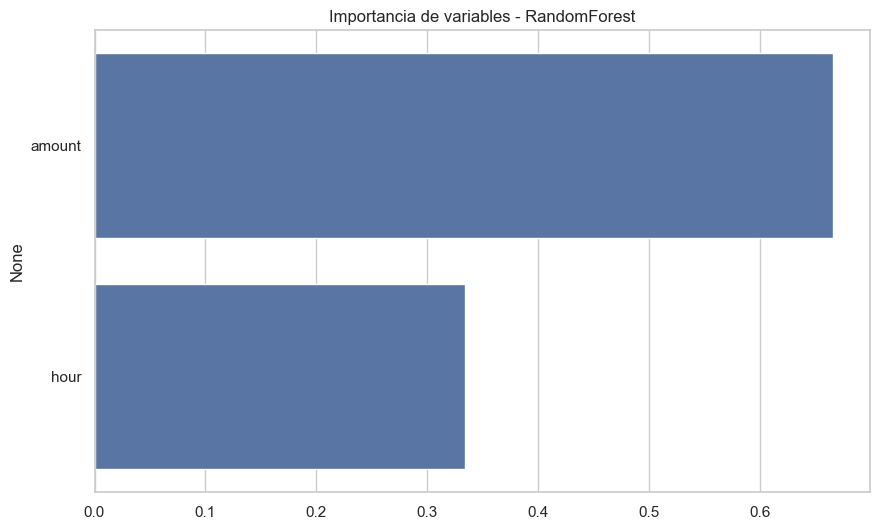

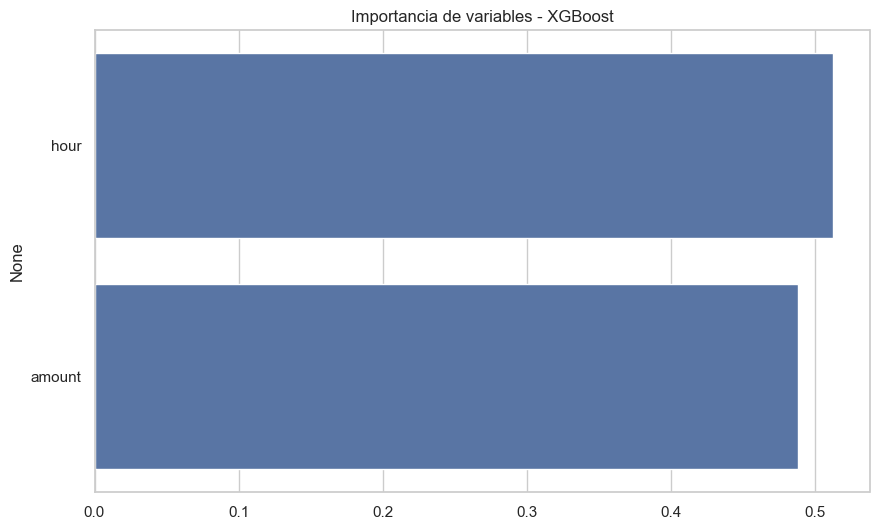

In [10]:
# Celda 9: Importancia de variables

import seaborn as sns
import matplotlib.pyplot as plt

# RandomForest feature importance
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Importancia de variables - RandomForest")
plt.show()

# XGBoost feature importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title("Importancia de variables - XGBoost")
plt.show()



📊 Importancia promedio de variables (SHAP - barras):


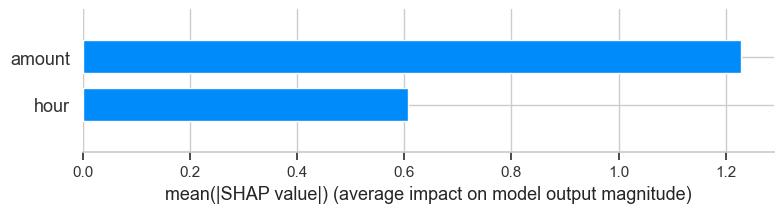

📊 Importancia detallada de variables (SHAP - dispersión):


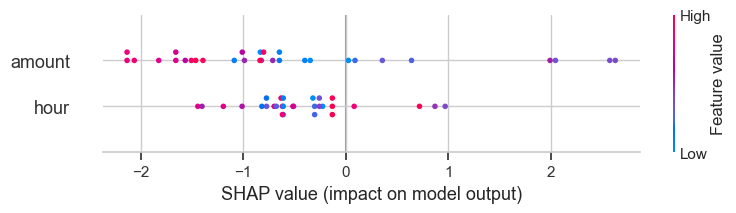

In [11]:
# Celda 10: SHAP values (barras + dispersión + interactivo)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import shap

# Crear el explainer con el modelo entrenado
explainer = shap.TreeExplainer(xgb_model)   # ✅ usar el modelo, no el módulo
shap_values = explainer(X_test)

print("📊 Importancia promedio de variables (SHAP - barras):")
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("📊 Importancia detallada de variables (SHAP - dispersión):")
shap.summary_plot(shap_values, X_test)


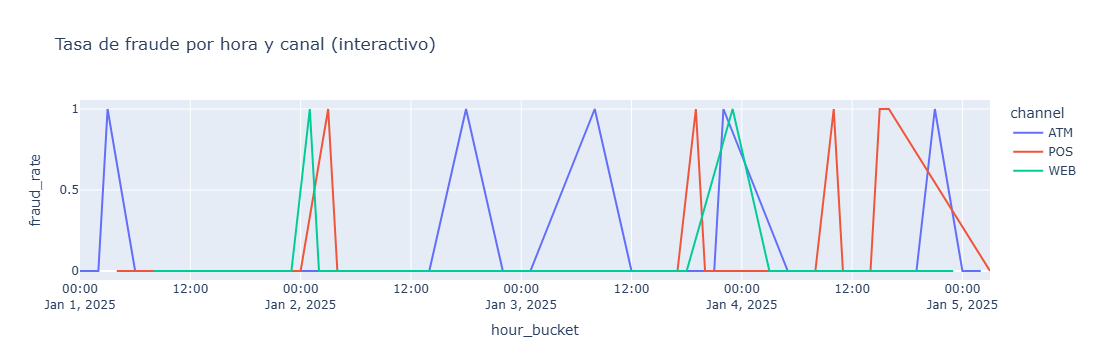

In [12]:
# Celda 11: Dashboard interactivo con Plotly
import plotly.express as px

fig = px.line(agg, x="hour_bucket", y="fraud_rate", color="channel",
              title="Tasa de fraude por hora y canal (interactivo)")
fig.show()


In [13]:
# Celda 12: Mostrar resultados en el notebook en lugar de exportar a Excel

print("📊 Datos originales (primeras filas):")
display(df.head())

print("📊 Agregados de fraude por canal y hora:")
display(agg.head(10))

print("📊 Resultados de modelos de colas:")
display(df_queues)

print("📊 Top reglas de asociación:")
display(top_rules[["antecedents","consequents","support","confidence","lift"]])

print("📊 Reporte RandomForest (Weighted Avg y Macro Avg):")
display(rf_report.loc[["weighted avg","macro avg"]][["precision","recall","f1-score"]])

print("📊 Reporte XGBoost (Weighted Avg y Macro Avg):")
display(xgb_report.loc[["weighted avg","macro avg"]][["precision","recall","f1-score"]])



📊 Datos originales (primeras filas):


,amount,channel,timestamp,is_fraud,hour_bucket,fraud_flag_int,is_high_amount,is_night,hour
0,112,ATM,2025-01-01 00:00:00,0,2025-01-01 00:00:00,0,False,True,0
1,445,ATM,2025-01-01 01:00:00,0,2025-01-01 01:00:00,0,False,True,1
2,870,ATM,2025-01-01 02:00:00,0,2025-01-01 02:00:00,0,False,True,2
3,280,ATM,2025-01-01 03:00:00,1,2025-01-01 03:00:00,1,False,True,3
4,116,POS,2025-01-01 04:00:00,0,2025-01-01 04:00:00,0,False,True,4


📊 Agregados de fraude por canal y hora:


,hour_bucket,channel,tx_count,fraud_count,fraud_rate
0,2025-01-01 00:00:00,ATM,1,0,0.0
1,2025-01-01 01:00:00,ATM,1,0,0.0
2,2025-01-01 02:00:00,ATM,1,0,0.0
3,2025-01-01 03:00:00,ATM,1,1,1.0
4,2025-01-01 04:00:00,POS,1,0,0.0
5,2025-01-01 05:00:00,POS,1,0,0.0
6,2025-01-01 06:00:00,ATM,1,0,0.0
7,2025-01-01 07:00:00,POS,1,0,0.0
8,2025-01-01 08:00:00,WEB,1,0,0.0
9,2025-01-01 09:00:00,ATM,1,0,0.0


📊 Resultados de modelos de colas:


,Modelo,Estable,Rho,P_espera,Lq,Wq_min,W_min,L
0,M/M/1,False,1.0,NaN,NaN,NaN,NaN,NaN
1,M/M/c,True,0.2,0.003831,0.000958,0.004789,5.004789,1.000958


📊 Top reglas de asociación:


,antecedents,consequents,support,confidence,lift
0,(is_fraud),(channel_ATM),0.05,0.416667,1.602564
1,(channel_ATM),(is_fraud),0.05,0.192308,1.602564
5,(is_night),(channel_ATM),0.08,0.285714,1.098901
4,(channel_ATM),(is_night),0.08,0.307692,1.098901
3,(channel_POS),(is_fraud),0.05,0.128205,1.068376
2,(is_fraud),(channel_POS),0.05,0.416667,1.068376
6,(channel_POS),(is_night),0.11,0.282051,1.007326
7,(is_night),(channel_POS),0.11,0.392857,1.007326


📊 Reporte RandomForest (Weighted Avg y Macro Avg):


,precision,recall,f1-score
weighted avg,0.81,0.9,0.852632
macro avg,0.45,0.5,0.473684


📊 Reporte XGBoost (Weighted Avg y Macro Avg):


,precision,recall,f1-score
weighted avg,0.806897,0.866667,0.835714
macro avg,0.448276,0.481481,0.464286


In [14]:
# Celda 13: Narrativa ejecutiva automática
summary_text = f"""
Resumen Ejecutivo:
- Se analizaron {len(df)} transacciones ficticias.
- La tasa de fraude promedio fue {df['is_fraud'].mean():.2%}.
- El modelo RandomForest obtuvo F1={rf_report.loc['weighted avg','f1-score']:.2f}.
- El modelo XGBoost obtuvo F1={xgb_report.loc['weighted avg','f1-score']:.2f}.
- El sistema de colas M/M/1 resultó {'estable' if mm1['Estable'] else 'inestable'} con rho={mm1['Rho']:.2f}.
- El sistema M/M/c resultó {'estable' if mmc['Estable'] else 'inestable'} con rho={mmc['Rho']:.2f}.
"""

print(summary_text)



Resumen Ejecutivo:
- Se analizaron 100 transacciones ficticias.
- La tasa de fraude promedio fue 12.00%.
- El modelo RandomForest obtuvo F1=0.85.
- El modelo XGBoost obtuvo F1=0.84.
- El sistema de colas M/M/1 resultó inestable con rho=1.00.
- El sistema M/M/c resultó estable con rho=0.20.



In [15]:
# Celda 14: Simulación de reducción de alertas irrelevantes
lambda_h_reduced = df["is_fraud"].sum() * 0.7  # reducción del 30% en alertas
mmc_reduced = mmc_metrics(lambda_h_reduced/60, mu_h/60, c)

print("📊 Colas con reducción de alertas irrelevantes:")
display(pd.DataFrame([mmc, mmc_reduced], index=["Original","Reducido"]))


📊 Colas con reducción de alertas irrelevantes:


,Modelo,Estable,Rho,P_espera,Lq,Wq_min,W_min,L
Original,M/M/c,True,0.20,0.003831,0.000958,0.004789,5.004789,1.000958
Reducido,M/M/c,True,0.14,0.000809,0.000132,0.000940,5.000940,0.700132


In [16]:
# Celda 15: Conclusiones finales
print("✅ Conclusiones:")
print("- Los modelos entrenados permiten detectar fraude con métricas aceptables en un dataset ficticio.")
print("- La interpretabilidad (feature importance, SHAP) muestra qué variables son más relevantes.")
print("- El análisis de colas evidencia la necesidad de ajustar agentes o automatización.")
print("- Las reglas de asociación aportan insights adicionales sobre patrones de fraude.")
print("- El reporte exportado resume todo en tablas y métricas para stakeholders.")


✅ Conclusiones:
- Los modelos entrenados permiten detectar fraude con métricas aceptables en un dataset ficticio.
- La interpretabilidad (feature importance, SHAP) muestra qué variables son más relevantes.
- El análisis de colas evidencia la necesidad de ajustar agentes o automatización.
- Las reglas de asociación aportan insights adicionales sobre patrones de fraude.
- El reporte exportado resume todo en tablas y métricas para stakeholders.


Tiempo esperado hasta el próximo fraude: 6.00 minutos


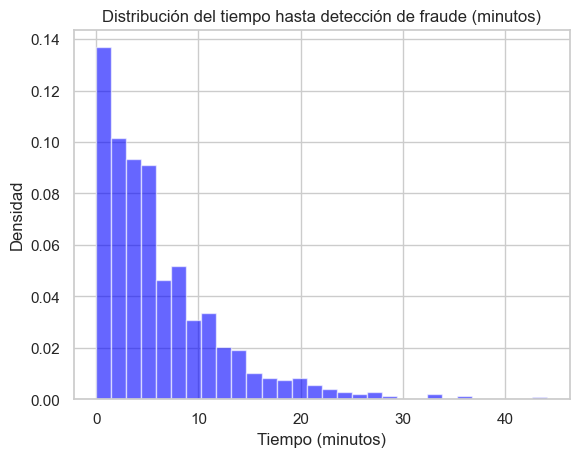

In [17]:
# Proceso de Poisson

import numpy as np
import matplotlib.pyplot as plt

# Supongamos que detectamos 10 fraudes en 1 hora
lambda_rate = 10  # fraudes por hora

# Tiempo esperado hasta el próximo fraude
expected_time = 1 / lambda_rate
print(f"Tiempo esperado hasta el próximo fraude: {expected_time*60:.2f} minutos")

# Simulación de tiempos de detección (distribución exponencial)
n_samples = 1000
times = np.random.exponential(scale=1/lambda_rate, size=n_samples)

# Graficar histograma
plt.hist(times*60, bins=30, density=True, alpha=0.6, color='blue')
plt.title("Distribución del tiempo hasta detección de fraude (minutos)")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Densidad")
plt.show()
